# Setup

In [1]:
pip install -r ../../requirements.txt

Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys; sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-05-28 13:24:28.595039: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 13:24:29.247382: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-28 13:24:29.247444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27236 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:25:00.0, compute capability: 7.0


In [6]:
config = json.load(open("./configs/ext_mnn_em.json"))

# Loading data

In [7]:
from data_loader.abo import ABO

In [8]:
data = ABO(
    path=config["data"]["path"],
    download=True,
    extract=False,
    preprocess=True,
    alt_augment=False,
    random_deletion=True,
    export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'description2', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Performing random deletion...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,description2,path,product_type,label
0,mobile coverb07td993m6amazon brand - solimo de...,b07td993m6,e6/e60bddd8.jpg,CELLULAR_PHONE_CASE,1
1,b07t8pzjt7,b07t9tjzsmamazon brand - solimo designer blue ...,7c/7ca803de.jpg,CELLULAR_PHONE_CASE,0
2,b08541fqxzamazon brand - solimo designer sky p...,amazon brand - solimo designer sky photography...,fd/fdf0f1a4.jpg,CELLULAR_PHONE_CASE,1
3,amazon brand - solimo designer orange slice 3d...,b07tqhbdnq,af/afeed073.jpg,FACIAL_TISSUE,0
4,b003jbhqp4,b003jbhqp4amazonbasics 21-in-1 usb 2.0 flash m...,a3/a3c61ff7.jpg,MEMORY_READER,1
...,...,...,...,...,...
141752,amazon brand - solimo designer black & white p...,shoesb07th3b83camazon brand - solimo designer ...,8a/8aba2daa.jpg,CELLULAR_PHONE_CASE,0
141753,mobile coveramazon brand - solimo designer ora...,formal shoes for mens leatherb0856346hv,a6/a62c2e70.jpg,CELLULAR_PHONE_CASE,0
141754,b08549p5v4365 everyday value organic wtg dark ...,mobile cover,24/24ece65e.jpg,CELLULAR_PHONE_CASE,0
141755,mobile coverb0843b2l83amazon brand - solimo de...,cellphonecovernubeno men's cherry formal shoes...,20/200283d8.jpg,CELLULAR_PHONE_CASE,0


In [9]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
text2 = data["description2"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [10]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(141757, 1014)

In [11]:
text2 = tk.tokenize(text2)
text2.shape

(141757, 1014)

## Create embedding weights

In [12]:
weights = tk.create_embedding_weights()
weights.shape

(66, 65)

# Image processing

## Load image model

In [13]:
from utils.img_processing import load_img_model, create_embeddings_from

In [14]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [15]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"), batch_size=2048)

In [16]:
img.shape

(141763, 1)

# Save embeddings

In [15]:
save_path = os.path.join(config["data"]["path"], f"embeddings/{img_model.name}")

In [18]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
np.save(f"{save_path}/text2.npy", text2)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [16]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,"365 everyday value reduced fat milk, 16 oz",8a/8a8d3c0c.jpg,GROCERY,1
1,b08569tzf4,b3/b3d38943.jpg,HEADBOARD,0
2,"find. women's 43510 boots, black black 01, 8 us",e3/e3a0e881.jpg,CELLULAR_PHONE_CASE,0
3,amazon brand - solimo designer lake view uv pr...,e7/e7d8c484.jpg,CELLULAR_PHONE_CASE,1
4,b079qclq1yamazon brand - solimo designer stone...,57/57e8f627.jpg,GROCERY,0
...,...,...,...,...
141816,b07tc5wzqzamazon brand - solimo designer water...,d3/d3960a36.jpg,CELLULAR_PHONE_CASE,0
141817,mobile coverb0856b24vlamazon brand - solimo de...,e1/e1d850a9.jpg,SHOES,0
141818,amazon brand - solimo designer queen 3d printe...,2d/2da26748.jpg,CELLULAR_PHONE_CASE,0
141819,b07t9tkrphamazon brand - solimo designer golde...,69/69181e4f.jpg,CELLULAR_PHONE_CASE,0


In [17]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(141821, 1)

In [18]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(141821, 1014)

In [19]:
text2 = np.load(f"{save_path}/text2.npy", allow_pickle=True)
text2.shape

(141899, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [20]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [21]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=config["ext_mnn_em"]["training"]["test_split"], random_state=42)

In [24]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

text2_train = text2[train.index]
text2_test = text2[test.index]

# Save Char CNN config

In [25]:
from models.char_cnn_zhang import CharCNNZhang

In [26]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [27]:
char_cnn = CharCNNZhang(**char_cnn_config)
char_cnn.model

# Build Extended MNN-EM Model

![](../../assets/images/Extended_MNN_EM.png)

In [28]:
from models.mnn_em import ExtendedMNNEM
from utils.eval import create_metrics

In [29]:
head_1_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["ext_mnn_em"]["img_1_fc_layers"],
    "txt_fc_layers": config["ext_mnn_em"]["txt_1_fc_layers"],
    "extended": True,
}

In [30]:
head_2_config = {
    "img_input_size": config["ext_mnn_em"]["img_1_fc_layers"][-1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["ext_mnn_em"]["combined_1_fc_layers"],
    "txt_fc_layers": config["ext_mnn_em"]["txt_2_fc_layers"],
    "extended": False,
}

In [31]:
ext_mnn_em = ExtendedMNNEM(
    head_1_config=head_1_config,
    head_2_config=head_2_config,
    char_cnn=char_cnn.model,
    combined_fc_layers=config["ext_mnn_em"]["combined_2_fc_layers"],
    learning_rate=config["ext_mnn_em"]["training"]["learning_rate"],
    metrics=create_metrics(config["ext_mnn_em"]["training"]["metrics"]))

In [32]:
ext_mnn_em.model.summary(expand_nested=True)

Model: "Extended_MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 1024)         16127426    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                  

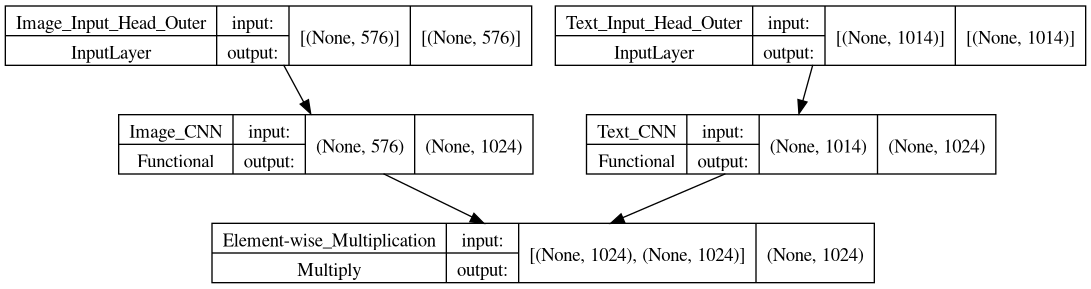

In [33]:
# "Head"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2], rankdir="TB", expand_nested=False, show_layer_activations=True, show_shapes=True)

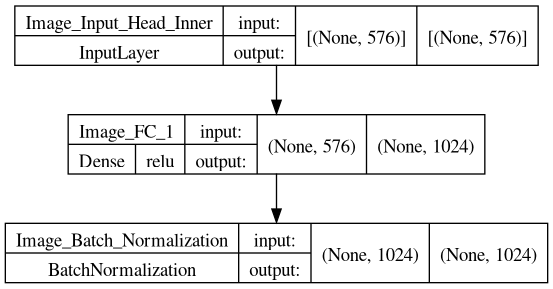

In [36]:
# Image CNN

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[2], rankdir="TB", show_layer_activations=True, show_shapes=True)

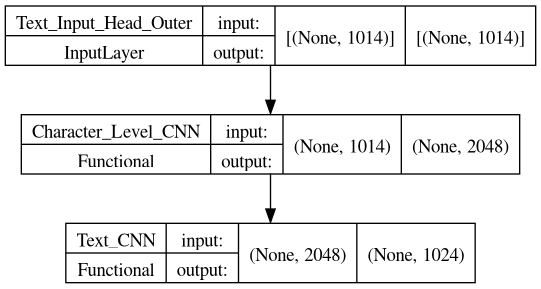

In [37]:
# Text CNN (outer)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3], rankdir="TB", show_layer_activations=True, show_shapes=True)

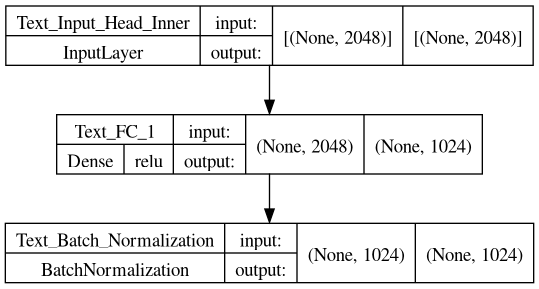

In [38]:
# Text CNN (inner)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3].layers[-1], rankdir="TB", show_layer_activations=True, show_shapes=True)

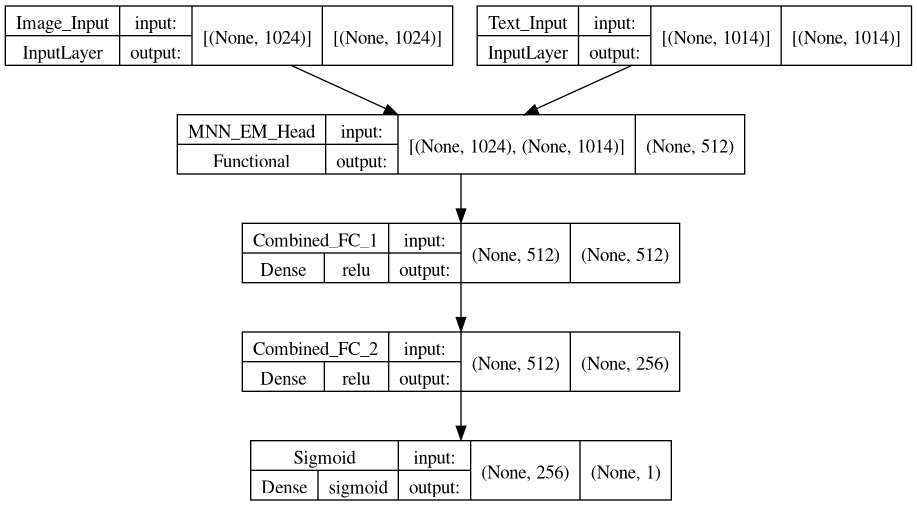

In [34]:
# "Tail"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[4], rankdir="TB", expand_nested=False, show_layer_activations=True, show_shapes=True)

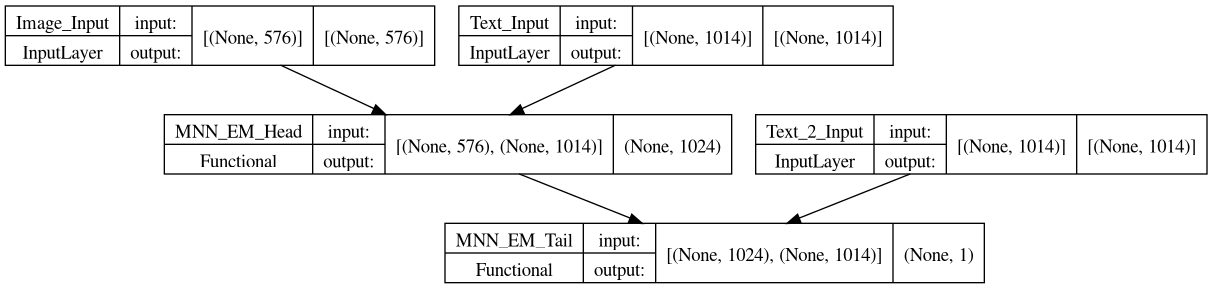

In [35]:
# Full model

tf.keras.utils.plot_model(ext_mnn_em.model, rankdir="TB", expand_nested=False, show_layer_activations=True, show_shapes=True)

# Callbacks

In [35]:
from utils.eval import create_callbacks

In [36]:
log_dir = config["ext_mnn_em"]["training"]["log_dir"]
model_name = config["ext_mnn_em"]["name"]
optimizer_name = config["ext_mnn_em"]["training"]["optimizer"]
learning_rate = config["ext_mnn_em"]["training"]["learning_rate"]

In [37]:
callbacks = create_callbacks(
    callbacks_list=config["ext_mnn_em"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"]
    )

# Training

In [39]:
history = ext_mnn_em.model.fit(
    x=[img_train, text_train, text2_train],
    y=labels_train,
    epochs=config["ext_mnn_em"]["training"]["epochs"],
    validation_split=config["ext_mnn_em"]["training"]["validation_split"],
    batch_size=config["ext_mnn_em"]["training"]["batch_size"], 
callbacks=callbacks)


Epoch 1/10


2023-05-25 19:25:37.461120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8901
2023-05-25 19:25:38.125564: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


7182/7182 [==============================] - ETA: 0s - loss: 4.6571 - recall: 0.6660 - precision: 0.5797 - binary_accuracy: 0.5915 - cosine_similarity: 0.5001

2023-05-25 19:27:40.252921: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 129s 17ms/step - loss: 4.6571 - recall: 0.6660 - precision: 0.5797 - binary_accuracy: 0.5915 - cosine_similarity: 0.5001 - val_loss: 1.5070 - val_recall: 0.8192 - val_precision: 0.6600 - val_binary_accuracy: 0.6958 - val_cosine_similarity: 0.5047
Epoch 2/10
7180/7182 [============================>.] - ETA: 0s - loss: 1.2362 - recall: 0.7303 - precision: 0.6773 - binary_accuracy: 0.6911 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 128s 18ms/step - loss: 1.2361 - recall: 0.7303 - precision: 0.6773 - binary_accuracy: 0.6911 - cosine_similarity: 0.5001 - val_loss: 1.0171 - val_recall: 0.8785 - val_precision: 0.6816 - val_binary_accuracy: 0.7316 - val_cosine_similarity: 0.5047
Epoch 3/10
7181/7182 [============================>.] - ETA: 0s - loss: 0.9240 - recall: 0.7899 - precision: 0.7220 - binary_accuracy: 0.7429 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 128s 18ms/step - loss: 0.9240 - recall: 0.7899 - precision: 0.7220 - binary_accuracy: 0.7429 - cosine_similarity: 0.5001 - val_loss: 0.7740 - val_recall: 0.9103 - val_precision: 0.7634 - val_binary_accuracy: 0.8123 - val_cosine_similarity: 0.5047
Epoch 4/10
7180/7182 [============================>.] - ETA: 0s - loss: 0.7193 - recall: 0.8600 - precision: 0.7947 - binary_accuracy: 0.8189 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 128s 18ms/step - loss: 0.7193 - recall: 0.8600 - precision: 0.7947 - binary_accuracy: 0.8189 - cosine_similarity: 0.5001 - val_loss: 0.6338 - val_recall: 0.9370 - val_precision: 0.8089 - val_binary_accuracy: 0.8565 - val_cosine_similarity: 0.5047
Epoch 5/10
7181/7182 [============================>.] - ETA: 0s - loss: 0.5931 - recall: 0.8954 - precision: 0.8278 - binary_accuracy: 0.8546 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 128s 18ms/step - loss: 0.5931 - recall: 0.8954 - precision: 0.8278 - binary_accuracy: 0.8545 - cosine_similarity: 0.5001 - val_loss: 0.5834 - val_recall: 0.9389 - val_precision: 0.8190 - val_binary_accuracy: 0.8644 - val_cosine_similarity: 0.5047
Epoch 6/10
7182/7182 [==============================] - ETA: 0s - loss: 0.5060 - recall: 0.9142 - precision: 0.8498 - binary_accuracy: 0.8763 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 128s 18ms/step - loss: 0.5060 - recall: 0.9142 - precision: 0.8498 - binary_accuracy: 0.8763 - cosine_similarity: 0.5001 - val_loss: 0.4811 - val_recall: 0.9502 - val_precision: 0.8499 - val_binary_accuracy: 0.8902 - val_cosine_similarity: 0.5047
Epoch 7/10
7179/7182 [============================>.] - ETA: 0s - loss: 0.4372 - recall: 0.9260 - precision: 0.8671 - binary_accuracy: 0.8920 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 129s 18ms/step - loss: 0.4372 - recall: 0.9260 - precision: 0.8671 - binary_accuracy: 0.8920 - cosine_similarity: 0.5001 - val_loss: 0.4260 - val_recall: 0.9446 - val_precision: 0.8671 - val_binary_accuracy: 0.8990 - val_cosine_similarity: 0.5047
Epoch 8/10
7180/7182 [============================>.] - ETA: 0s - loss: 0.3789 - recall: 0.9360 - precision: 0.8852 - binary_accuracy: 0.9073 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 129s 18ms/step - loss: 0.3789 - recall: 0.9360 - precision: 0.8852 - binary_accuracy: 0.9073 - cosine_similarity: 0.5001 - val_loss: 0.3731 - val_recall: 0.9538 - val_precision: 0.8861 - val_binary_accuracy: 0.9148 - val_cosine_similarity: 0.5046
Epoch 9/10
7180/7182 [============================>.] - ETA: 0s - loss: 0.3252 - recall: 0.9447 - precision: 0.9059 - binary_accuracy: 0.9233 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 130s 18ms/step - loss: 0.3252 - recall: 0.9447 - precision: 0.9059 - binary_accuracy: 0.9233 - cosine_similarity: 0.5001 - val_loss: 0.3576 - val_recall: 0.9635 - val_precision: 0.8918 - val_binary_accuracy: 0.9226 - val_cosine_similarity: 0.5045
Epoch 10/10
7179/7182 [============================>.] - ETA: 0s - loss: 0.2849 - recall: 0.9531 - precision: 0.9198 - binary_accuracy: 0.9350 - cosine_similarity: 0.5001

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7182/7182 [==============================] - 129s 18ms/step - loss: 0.2849 - recall: 0.9530 - precision: 0.9198 - binary_accuracy: 0.9350 - cosine_similarity: 0.5001 - val_loss: 0.3194 - val_recall: 0.9697 - val_precision: 0.9034 - val_binary_accuracy: 0.9324 - val_cosine_similarity: 0.5045


# Evaluation

## Plot loss and metrics

In [40]:
from utils.eval import plot_metrics

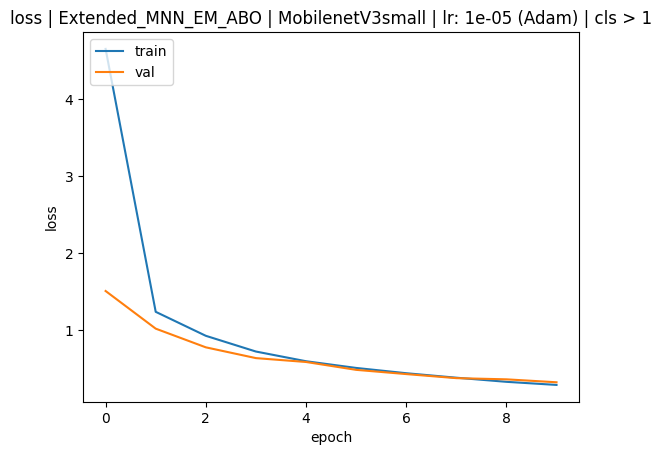

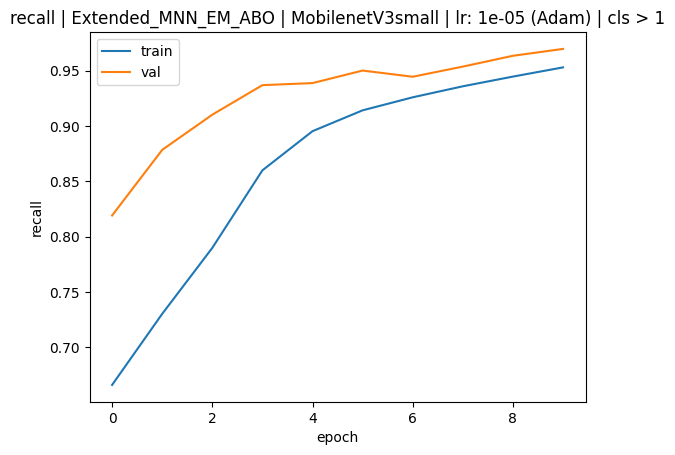

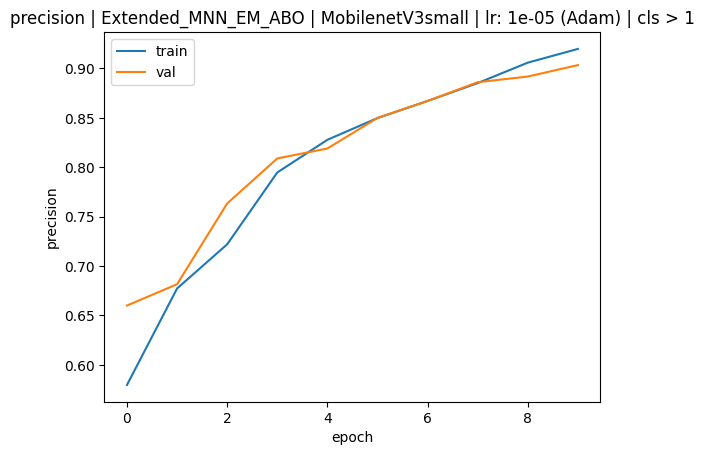

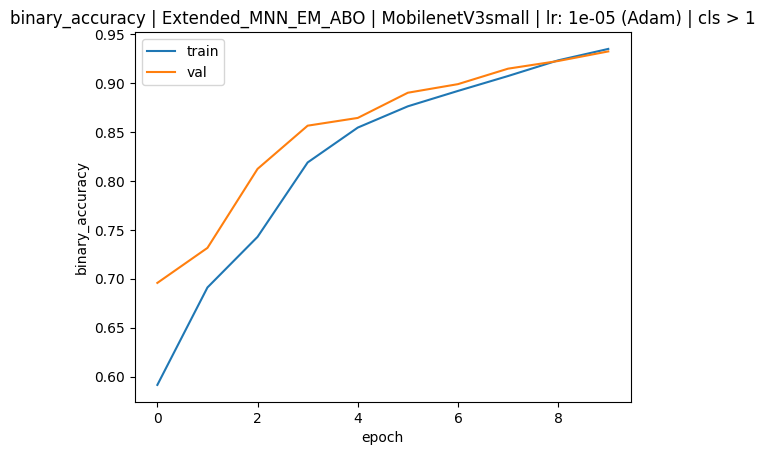

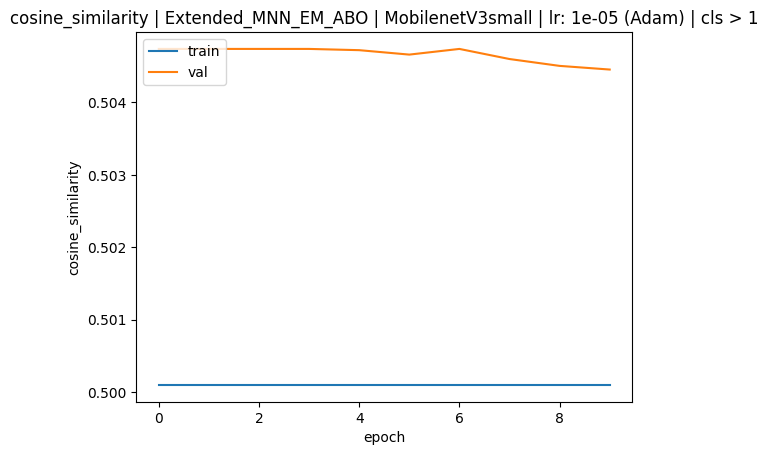

In [41]:
plot_metrics(history.history, config["ext_mnn_em"]["training"]["metrics"], model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

## Evaluate model and save metrics

In [39]:
from utils.eval import evaluate

In [40]:
evaluate(ext_mnn_em.model, [img_test, text_test, text2_test], labels_test, log_dir, model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

2023-05-25 19:55:21.472349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8901


   30/14186 [..............................] - ETA: 49s - loss: 0.2044 - recall: 0.9412 - precision: 1.0000 - binary_accuracy: 0.9667 - cosine_similarity: 0.5667               

2023-05-25 19:55:22.102085: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


14186/14186 [==============================] - 49s 3ms/step - loss: 0.3096 - recall: 0.9680 - precision: 0.9005 - binary_accuracy: 0.9301 - cosine_similarity: 0.5028
